In [5]:
%matplotlib notebook
import lightkurve as lk
import matplotlib.pyplot as plt
import scipy
lcflist = lk.search_lightcurvefile('TIC 150437899').download_all()

<IPython.core.display.Javascript object>


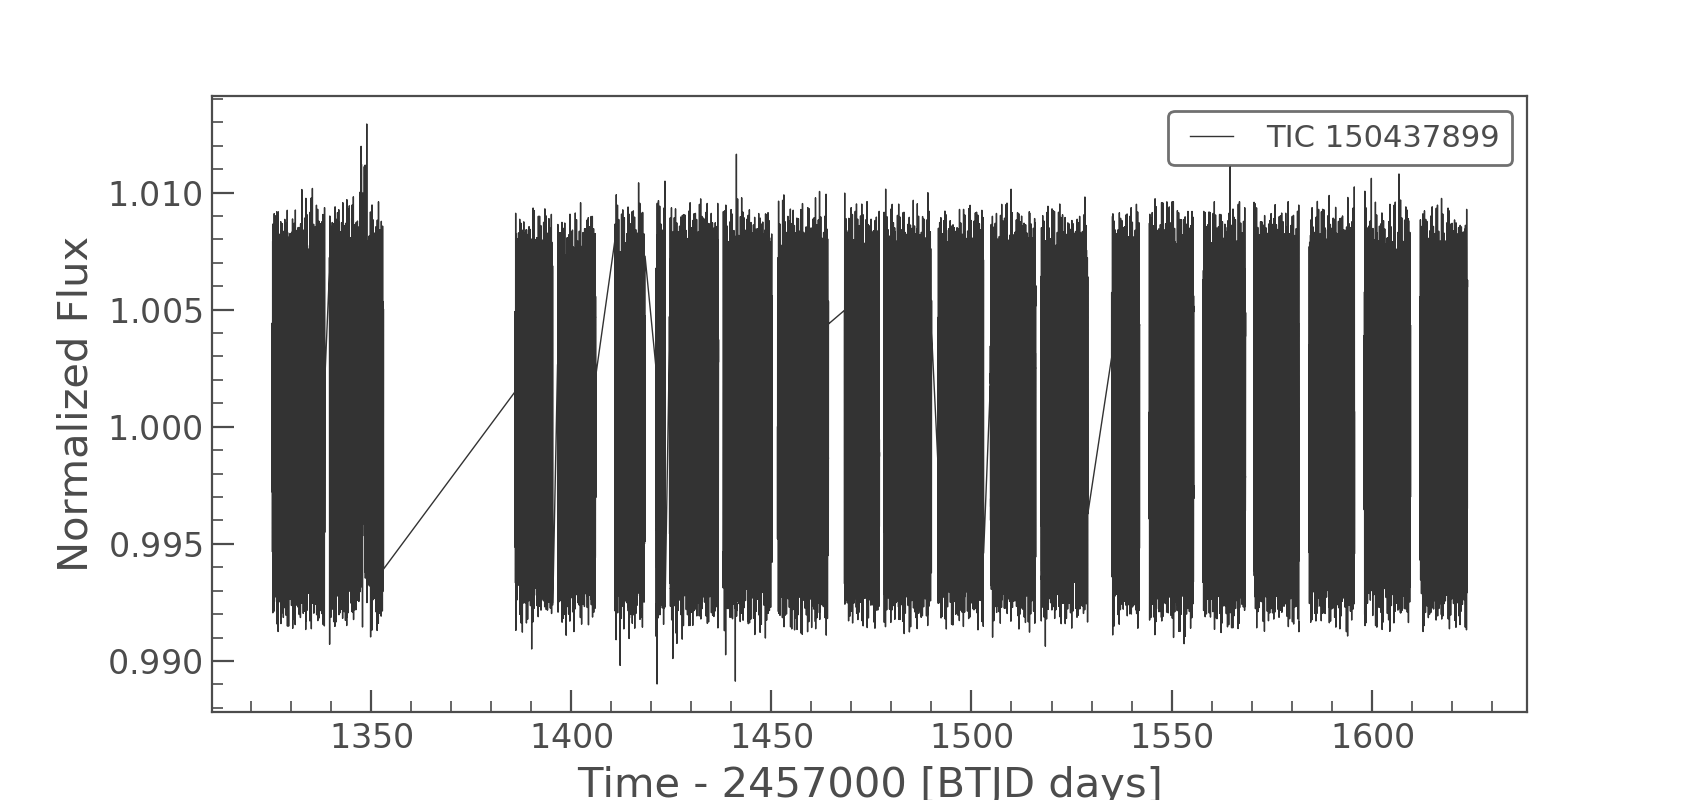

In [6]:
lc = lcflist[0].PDCSAP_FLUX.normalize().flatten(window_length=201,break_tolerance=10)
for value in lcflist[1:]:
    lc = lc.append(value.PDCSAP_FLUX.normalize().flatten(window_length=201,break_tolerance=10))
    
lc.plot()

<IPython.core.display.Javascript object>


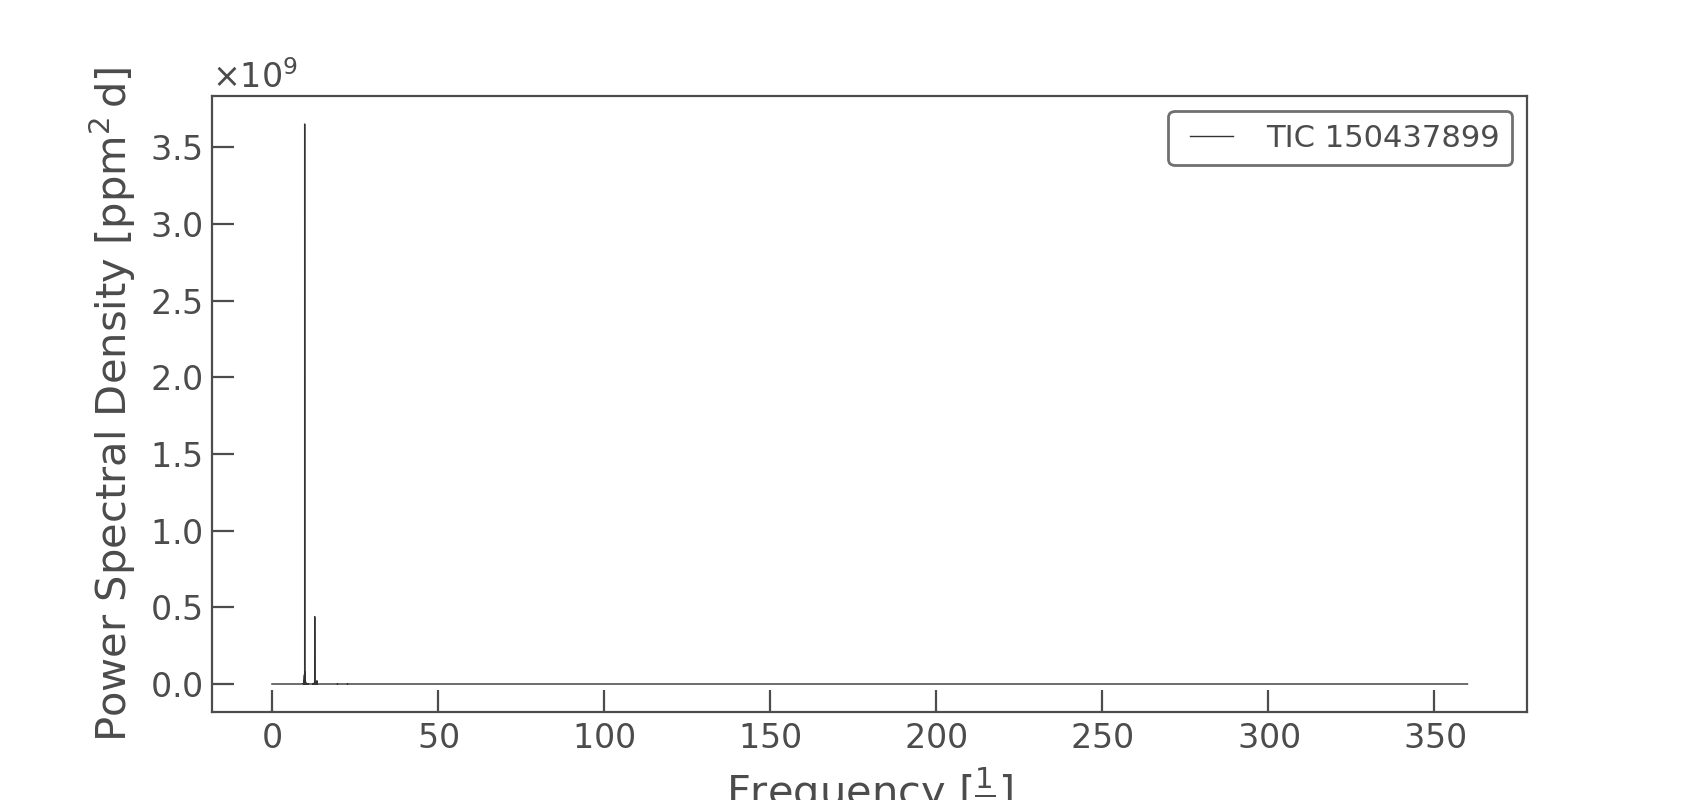

<IPython.core.display.Javascript object>


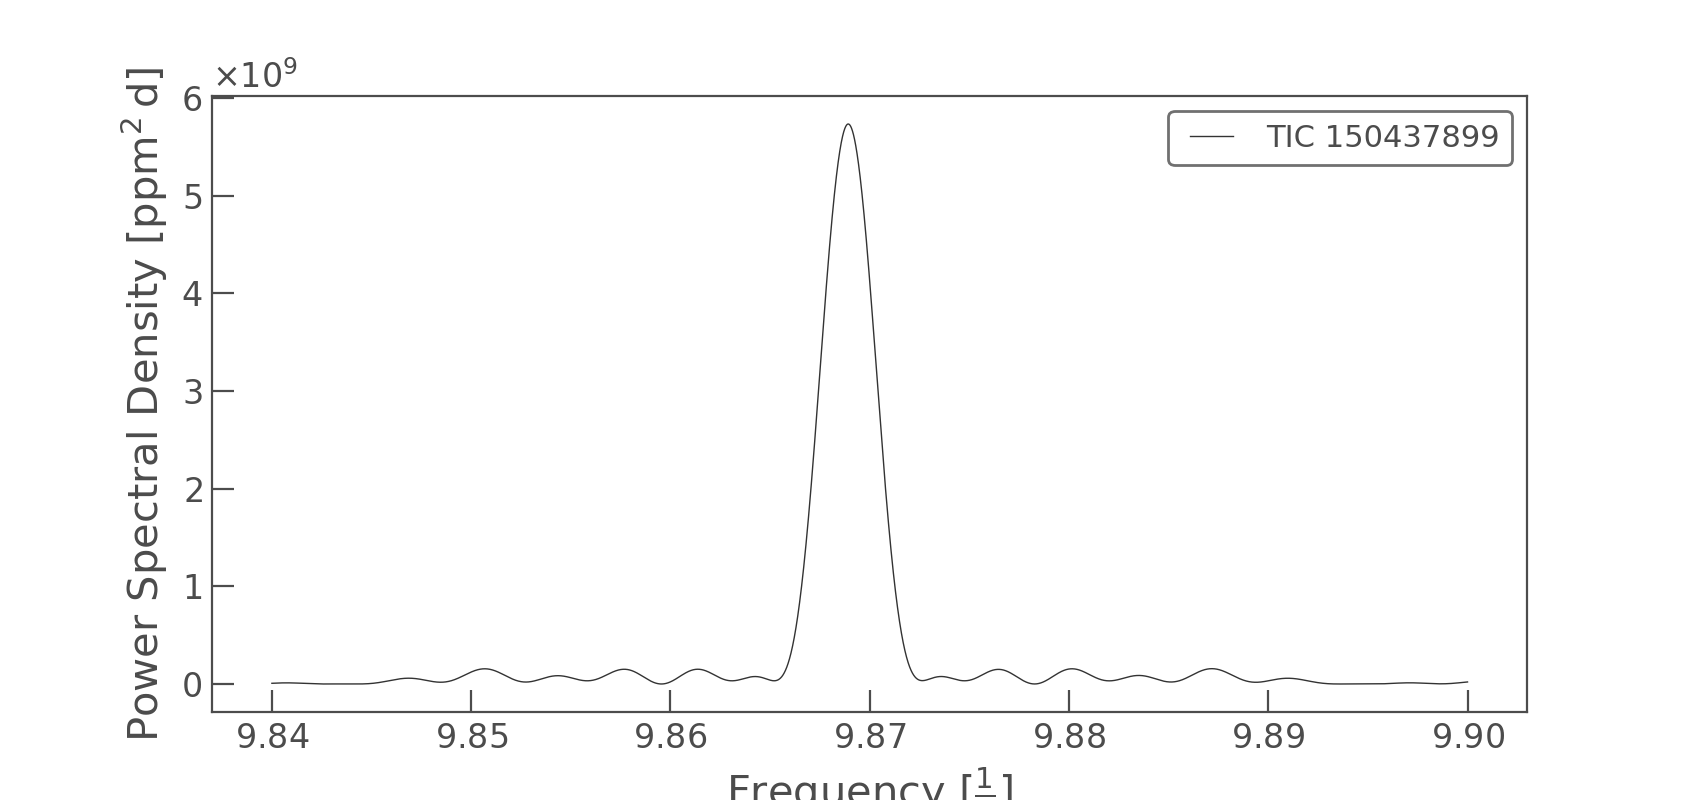

<IPython.core.display.Javascript object>


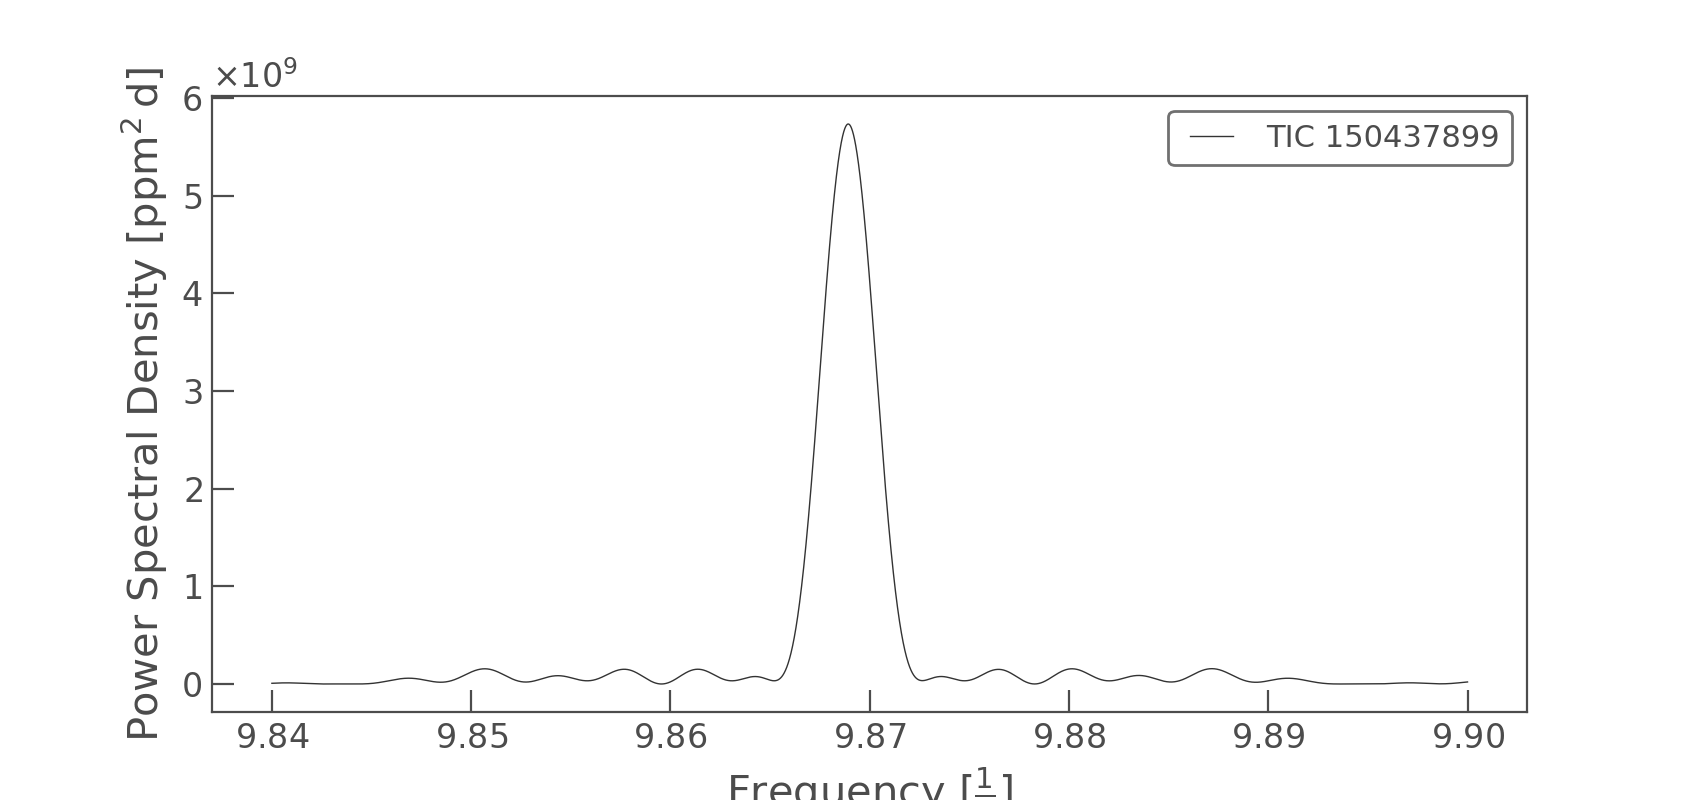

In [7]:
pg1 = lc.remove_nans().to_periodogram()
pg1.plot()
pg = lc.remove_nans().to_periodogram(min_frequency = 9.84, max_frequency = 9.9, oversample_factor = 500, nyquist_factor = 4)
pg.plot()
pg2 = lc.remove_nans().to_periodogram(min_frequency = 13.55, max_frequency = 13.6, oversample_factor = 500, nyquist_factor = 4)
pg.plot()

<IPython.core.display.Javascript object>


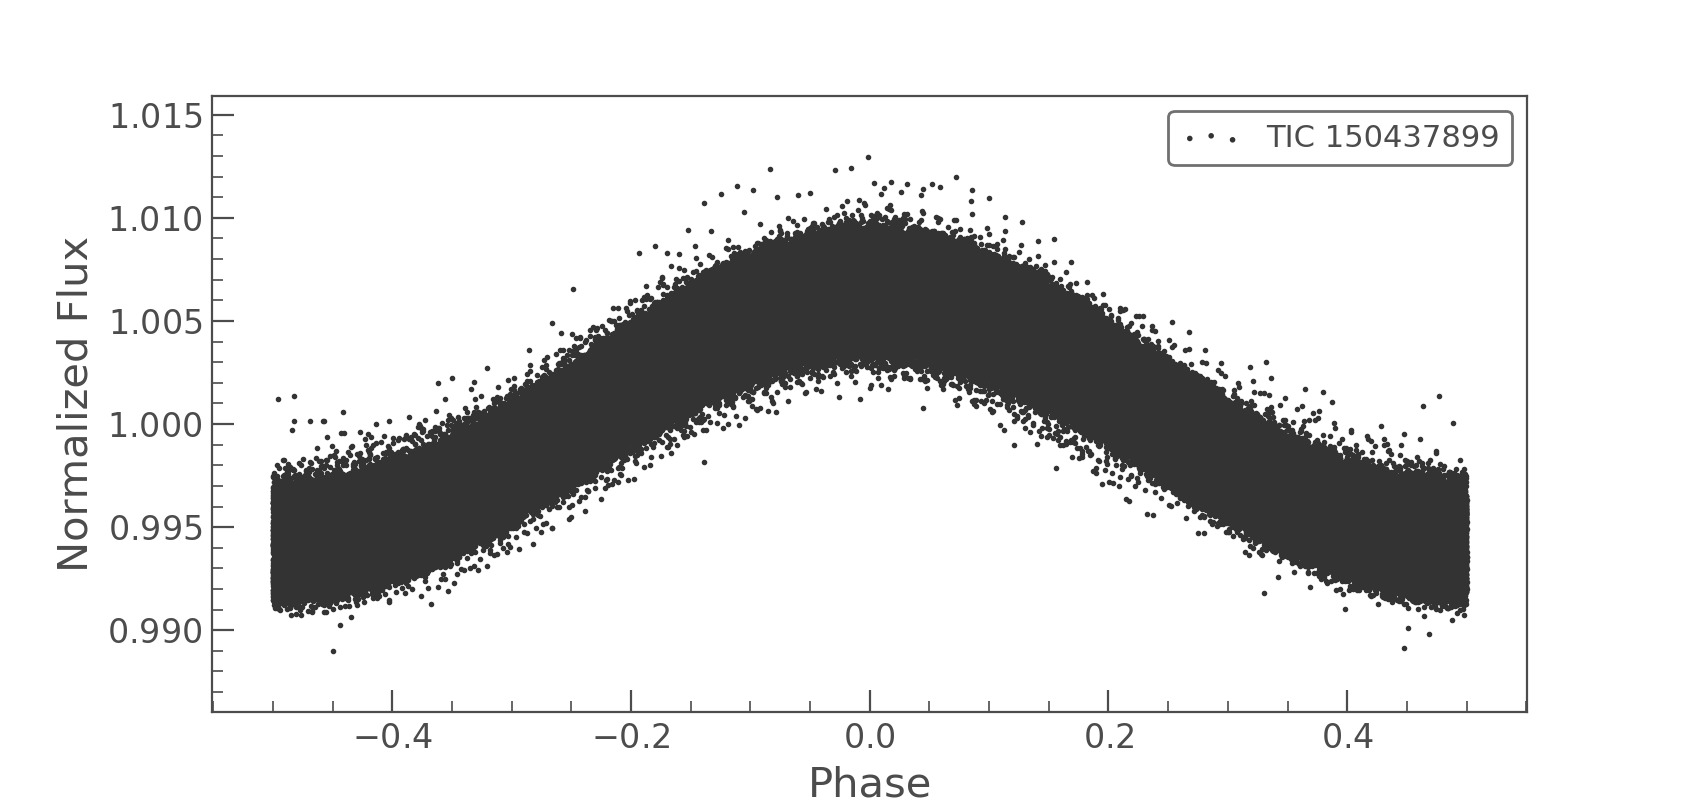

In [8]:
lc.fold(pg.period_at_max_power.value).scatter()
freq=pg.frequency_at_max_power.value

<IPython.core.display.Javascript object>


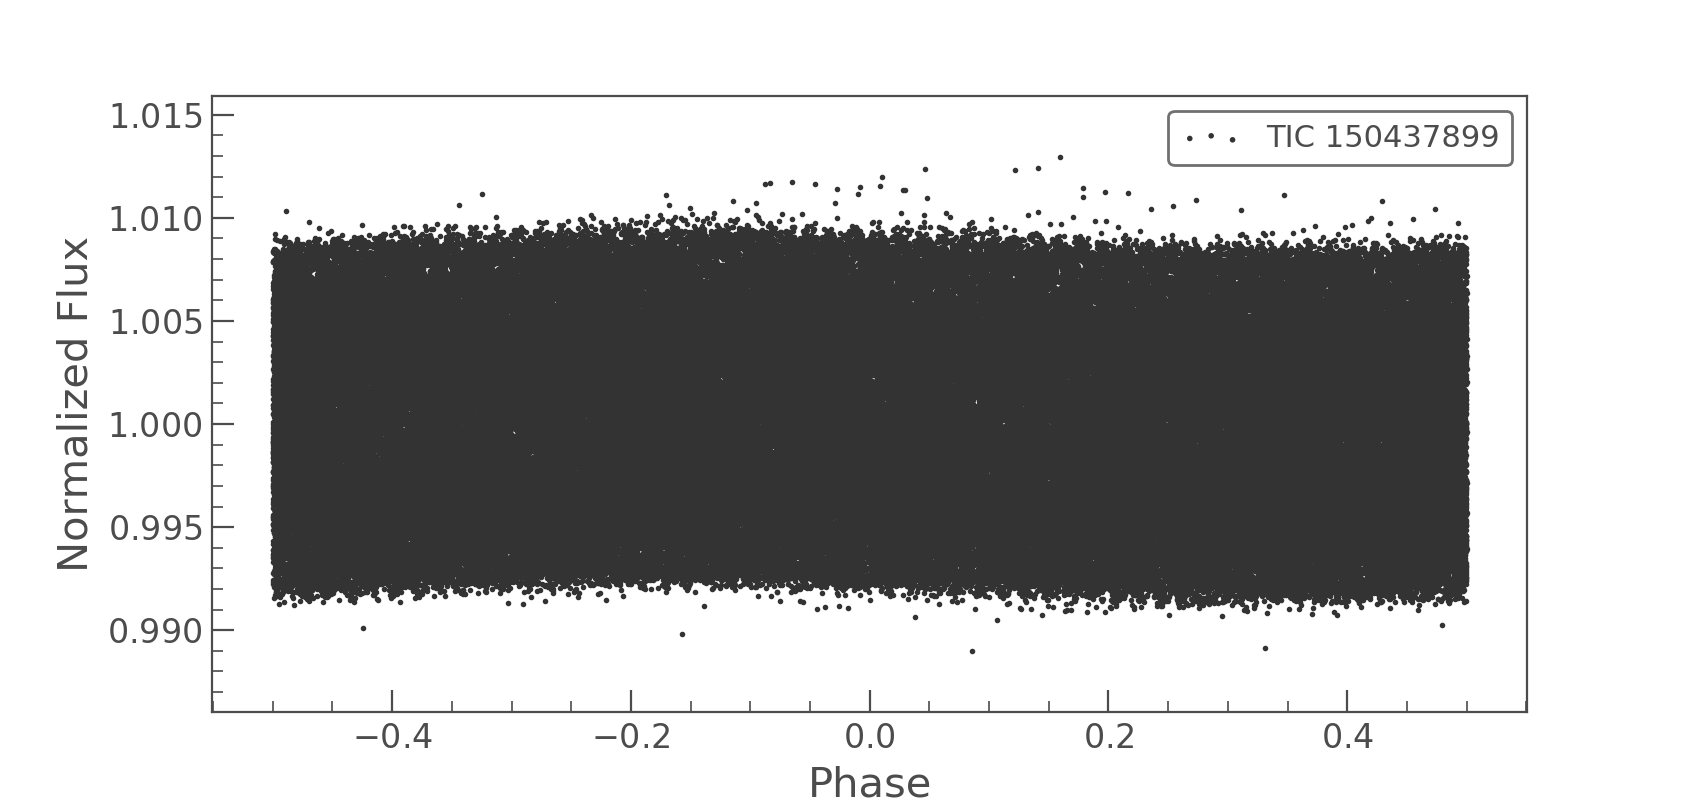

In [9]:
lc.fold(pg2.period_at_max_power.value).scatter()
freq2=pg2.frequency_at_max_power.value

In [10]:
def divide_chunks(l, n): 
  
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n]

In [11]:
def sinfunc(t,p, A):  return A * np.sin(2.*np.pi*freq*(t + p)) + 1.0
print(freq)

def sumofsins(t,p1,A1,p2,A2): return sinfunc(p1,A1)+sinfunc(p2,A2)

9.868915318951094


<IPython.core.display.Javascript object>


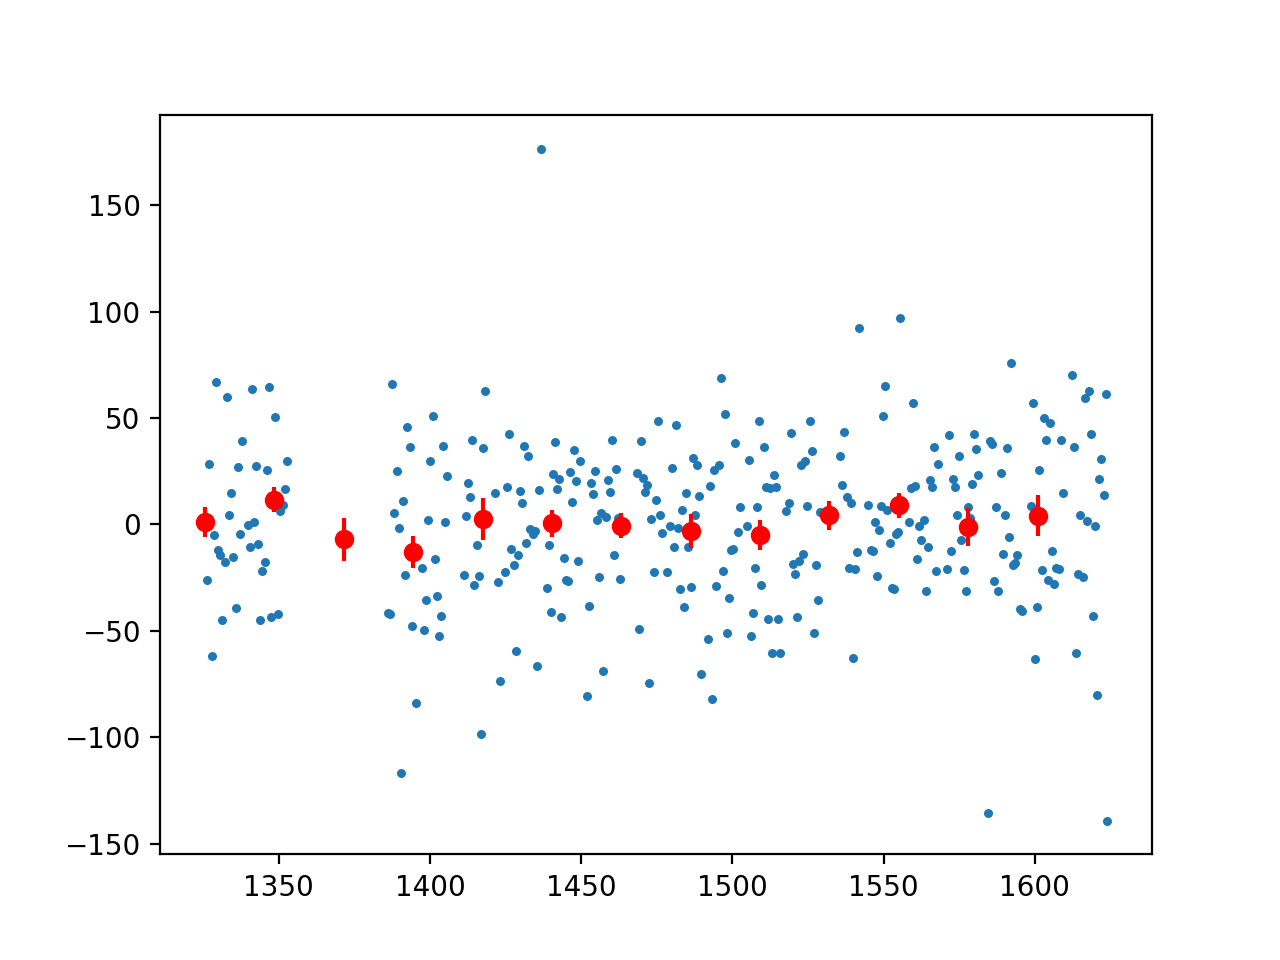

<Container object of 3 artists>

In [12]:
import numpy as np
lc = lc.remove_nans()
guess_amp = np.std(lc.flux) * 2.**0.5
num_sections = 500
time = list(divide_chunks(lc.time,num_sections))
flux = list(divide_chunks(lc.flux,num_sections))
import numpy as np
periodlist = []
mediantimelist = []
#iterate over every window
for index, interval in enumerate(time):
    guess = np.array([1325.31,guess_amp])
    popt, pcov = scipy.optimize.curve_fit(sinfunc, interval, flux[index], p0=guess)
    periodlist.append(popt[0])
    mediantimelist.append(np.median(interval))
fig = plt.figure()
ax = fig.add_subplot(111)

arr = scipy.stats.binned_statistic(mediantimelist, periodlist, 'mean', bins=13)
arr1 = scipy.stats.binned_statistic(mediantimelist, periodlist, np.std, bins=13)

ax.scatter(np.array(mediantimelist),86400*(np.array(periodlist)-np.mean(periodlist)),s=5)
ax.errorbar(arr[1][0:-1],(np.array(arr[0])-np.mean(periodlist))*86400,yerr = (arr1[0]*86400.0)/np.sqrt(arr[1][1]-arr[1][0]),fmt = 'o', c='red')

<IPython.core.display.Javascript object>


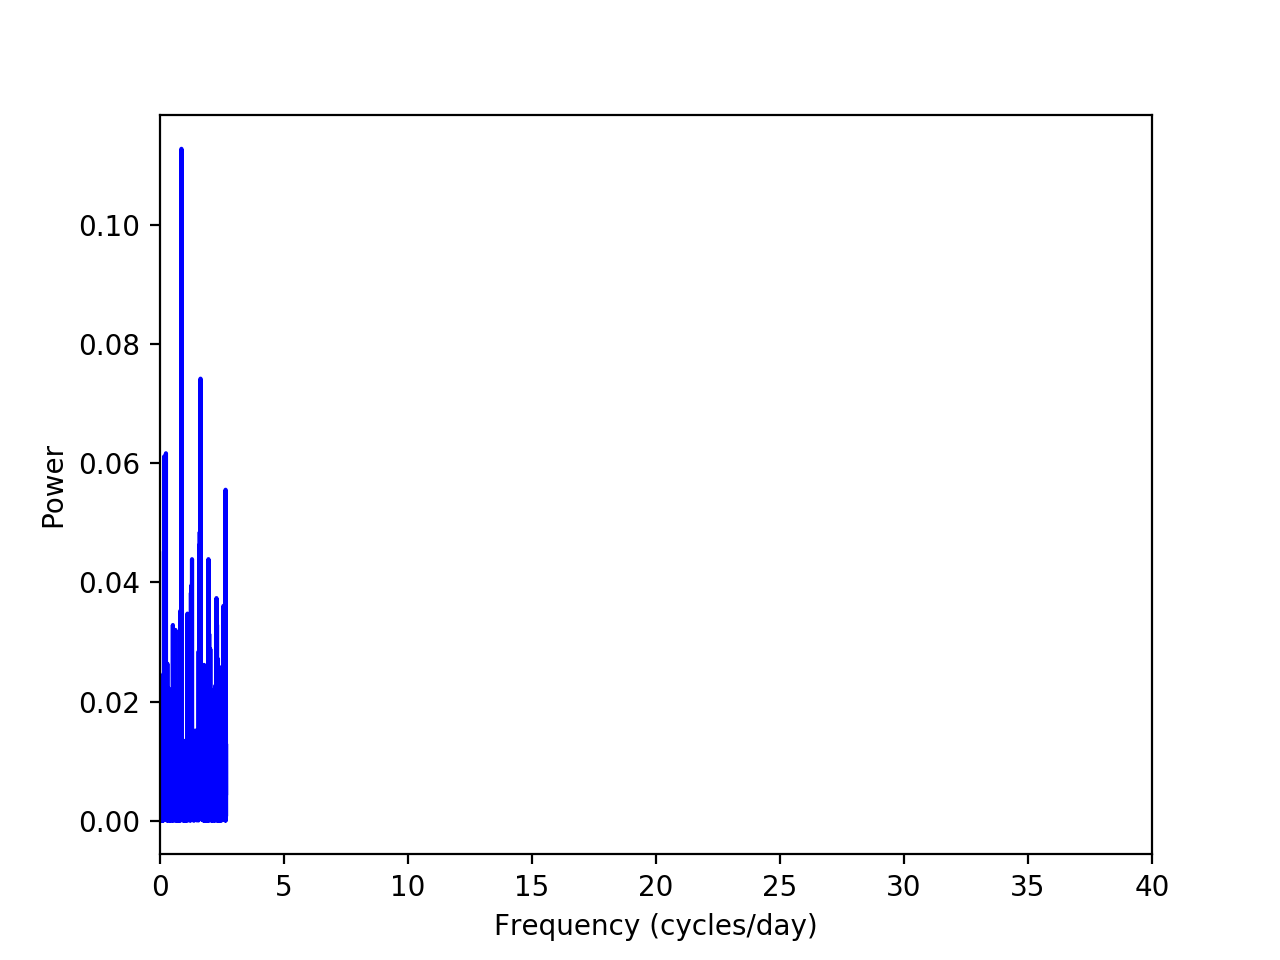

(0, 40)

In [13]:
%matplotlib notebook
from astropy.stats import LombScargle
frequency, power = LombScargle(np.array(mediantimelist),86400*(np.array(periodlist)-np.mean(periodlist))).autopower()
plt.clf()
plt.plot(frequency,power,c='blue')
plt.xlabel('Frequency (cycles/day)')
plt.ylabel('Power')
plt.xlim([0,40])

In [28]:
#BIC calculator
from lmfit import Model 
import math
def sine(x,t,b,a):
    return a*np.sin(2*t*math.pi*(x + b))
def line(x,m,c):
    return m*x + c
sinmodel = Model(sine)
params = sinmodel.make_params(t=200, b=1357, a=10)
y = 86400*(np.array(periodlist)-np.mean(periodlist))
x = np.array(mediantimelist)
result = sinmodel.fit(y, params, x=x)
print(result.fit_report())
print()
linemodel = Model(line)
params1 = linemodel.make_params(m=0, c=0)
result1 = linemodel.fit(y, params1, x=x)
print(result1.fit_report())


[[Model]]
    Model(sine)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 318
    # variables        = 3
    chi-square         = 441626.081
    reduced chi-square = 1401.98756
    Akaike info crit   = 2307.10125
    Bayesian info crit = 2318.38740
[[Variables]]
    t:  199.998324 +/- 8.4334e-04 (0.00%) (init = 200)
    b:  1357.02406 +/- 0.01198978 (0.00%) (init = 1357)
    a: -6.72312924 +/- 3.26976702 (48.63%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(t, b) = -1.000
    C(b, a) =  0.437
    C(t, a) = -0.437


[[Model]]
    Model(line)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 318
    # variables        = 2
    chi-square         = 448274.690
    reduced chi-square = 1418.59079
    Akaike info crit   = 2309.85301
    Bayesian info crit = 2317.37711
[[Variables]]
    m:  0.01833358 +/- 0.02514397 (137.15%) (init = 0)
    c: -27.2605781 